# Capstone Project - The Battle of Neighborhoods - Week 2

## Index

1. Introduction
2. Data Understanding
3. Data Preparation & Cleaning
4. Evaluation
5. Deployment
6. Conclusions

## 1. Introduction

New York City has the biggest population in the United States of America. Around 8,622,357 inhabitants. The population density is 27,755.25 people per square mile, with an area of 468.19 square miles. Food culture include an array of international cuisines influenced by the city’s immigrant history. In this study we will analyze public data to find insight, to open a new restaurant.

### Project Goals

- What is the best location in New York City for a Mexican restaurant?
- Which areas have potential Restaurant Market?
- Which all areas lack Mexican Restaurants?

## 2. Data Understanding  

New York City's have a diverse offer when it comes to restaurants, each belonging to different categories/countries or regions. For this project, we will use an the following open dataset: 

New York City data that contains a list of Boroughs and Neighborhoods along with their gps latitude and longitude.

Dataset: https://cocl.us/new_york_dataset

Restaurants in each neighborhood of New York City.

Data set: Foursquare API

GeoSpace data set

Data set : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description: Get the New York Borough boundaries to visualize in a choropleth map.

## 3. Data Preparation and Cleaning

### 3.1 Install and import necesary libraries

In [28]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium
# ! pip install folium==2.11.2
import folium # plotting library

# associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


### 3.2 Foursquare function

Define a function to interact with FourSquare API and get top 100 venues within a radius of 5000 metres for a given latitude and longitude. The function will return venue id, venue name and category:

In [29]:
CLIENT_ID = 'UMAHH11LV5ZCHZOSPLPTXCRMMH25ARQKISU2DGVAWRM3QWYN'
CLIENT_SECRET = '4QLBJT0HWROGTCJUEB144WIVJJ5DY31CFVLRPKBUU0LKN4BL'
VERSION = '20180604'
LIMIT = 100
radius=5000

In [30]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [31]:
# Place where we get the max ratings
address = 'New York, Manhattan'
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

Geograpical coordinate of New York, Manhattan are 40.7896239, -73.9598939.


In [32]:
def get_venues(lat,lng):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Test Function:

In [33]:
venues = get_venues(40.7896239, -73.9598939)
venues.head()

,ID,Name,Category
0,4ba233dbf964a5206fe337e3,East Meadow,Field
1,4a746fb2f964a52025de1fe3,The Jewish Museum,Museum
2,5328a418498e4be839240b62,Da Capo,Café
3,4a229fa8f964a520797d1fe3,Jacqueline Kennedy Onassis Reservoir,Reservoir
4,4a2fc4d3f964a520da981fe3,Cooper Hewitt Smithsonian Design Museum,Art Museum


In [34]:
venues.shape

(100, 3)

Define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking:

In [35]:
def get_venue_details(venue_id):
  
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Test Function:

In [36]:
get_venue_details(venue_id='4a2fc4d3f964a520da981fe3')

,ID,Name,Likes,Rating,Tips
0,4a2fc4d3f964a520da981fe3,Cooper Hewitt Smithsonian Design Museum,830,9.2,144


In [37]:
def get_new_york_data():
  
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Call funtion to get the New York City data:

In [38]:
new_york_data = get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [39]:
new_york_data.shape

(306, 4)

Saving New York data in csv format:

In [40]:
new_york_data.to_csv('new_york_data.csv', index=False)

Plotting the Neighborhoods in New York.

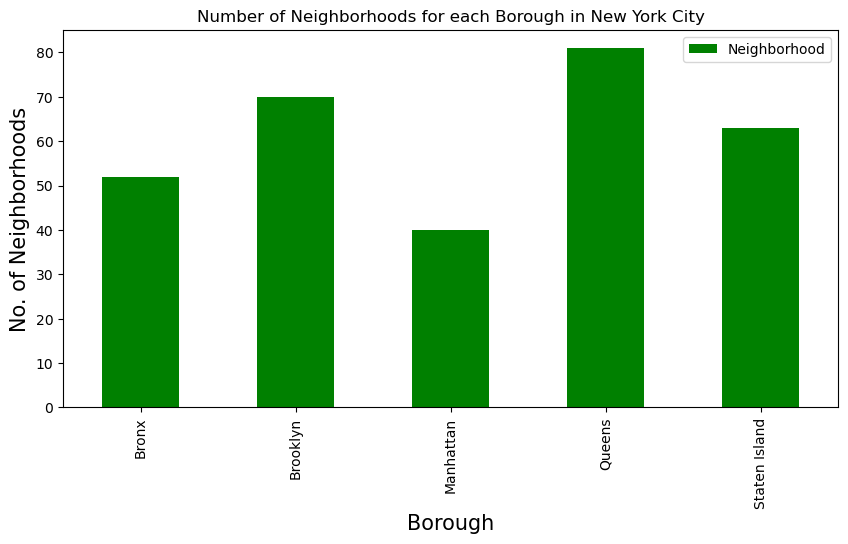

In [41]:
plt.figure(figsize=(10,5), dpi=100)
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize=15)
#On y-axis
plt.ylabel('No. of Neighborhoods', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar', color='green')
#legend
plt.legend()
#displays the plot
plt.show()

According to the plot, Queens has the higher number of neighborhoods while Manhattan has the lower.

Lets find out how many Mexican Restaurants are in each neighborhood:

In [42]:
# prepare neighborhood list that contains mexican resturants
column_names = ['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny = pd.DataFrame(columns=column_names)
count = 1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_resturants = venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(new_york_data),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(mexican_resturants)))
    for resturant_detail in mexican_resturants.values.tolist():
        id, name , category = resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Resturants in Wakefield, Bronx:1
( 2 / 306 ) Mexican Resturants in Co-op City, Bronx:4
( 3 / 306 ) Mexican Resturants in Eastchester, Bronx:2
( 4 / 306 ) Mexican Resturants in Fieldston, Bronx:4
( 5 / 306 ) Mexican Resturants in Riverdale, Bronx:4
( 6 / 306 ) Mexican Resturants in Kingsbridge, Bronx:4
( 7 / 306 ) Mexican Resturants in Marble Hill, Manhattan:5
( 8 / 306 ) Mexican Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Mexican Resturants in Norwood, Bronx:3
( 10 / 306 ) Mexican Resturants in Williamsbridge, Bronx:1
( 11 / 306 ) Mexican Resturants in Baychester, Bronx:3
( 12 / 306 ) Mexican Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Mexican Resturants in City Island, Bronx:3
( 14 / 306 ) Mexican Resturants in Bedford Park, Bronx:4
( 15 / 306 ) Mexican Resturants in University Heights, Bronx:3
( 16 / 306 ) Mexican Resturants in Morris Heights, Bronx:3
( 17 / 306 ) Mexican Resturants in Fordham, Bronx:3
( 18 / 306 ) Mexican Resturants in East Tremont, Bronx:

Lets explore Mexican Restaurants:

In [44]:
mexican_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,59e50faa3149b91759f70437,Chipotle Mexican Grill
1,Bronx,Co-op City,59e50faa3149b91759f70437,Chipotle Mexican Grill
2,Bronx,Co-op City,4e14ef8218a8addae8c57a0f,La Estrellita Poblana
3,Bronx,Co-op City,4bad4cebf964a520b8433be3,Mexico Magico Restaurant
4,Bronx,Co-op City,4b720280f964a520d9692de3,Estrellita Poblana IV


In [46]:
mexican_rest_ny.shape

(543, 4)

Saving the dataset into a csv file:

In [48]:
mexican_rest_ny.to_csv('mexican_rest_ny.csv', index=False)

## Exploring Mexican Restaurants in each borough and neighborhood

The following plot shows the number of Mexican resturants for each Borough in New York City:

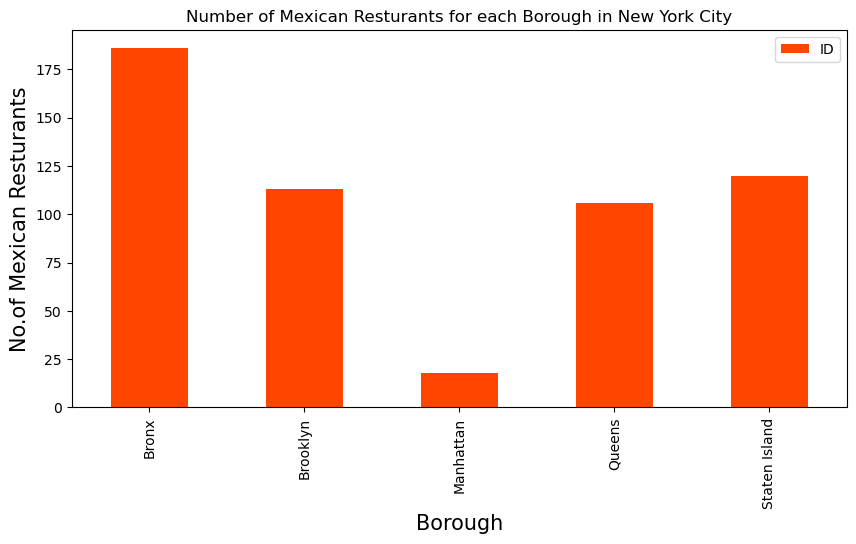

In [55]:
plt.figure(figsize=(10,5), dpi=100)
# title
plt.title('Number of Mexican Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize=15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
mexican_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar', color='orangered')
#legend
plt.legend()
#displays the plot
plt.show()

According to the plot, the Bronx has the higher number of Mexican Restaurants while Manhattan the lower.

The following plot shows the number of Mexican resturants for each Neighborhood in New York City:

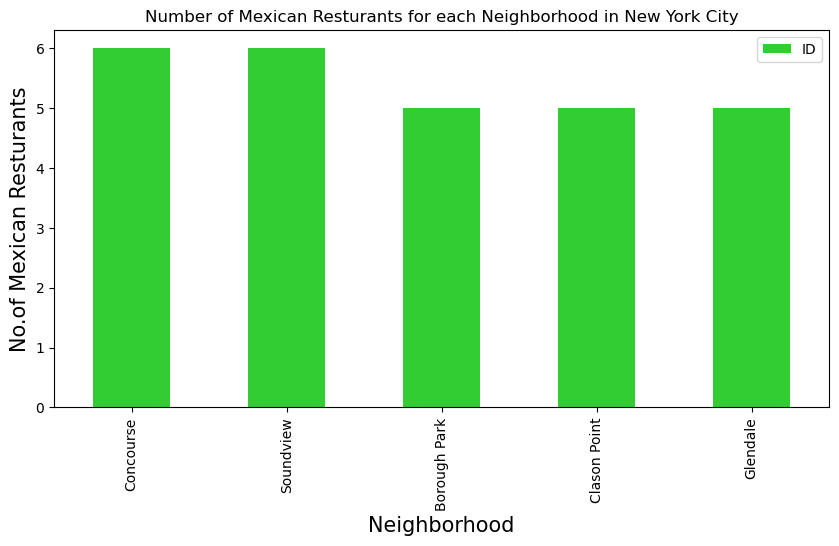

In [59]:
plt.figure(figsize=(10,5), dpi=100)
# title
plt.title('Number of Mexican Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize=15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
brazilian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar', color='limegreen')
#legend
plt.legend()
#displays the plot
plt.show()

As we can see in the plot, Concourse and Soundview have the highes (and equal) number of Mexican Restaurants while Borough Park, Clason Point and Glendale have the lowes (and equal) number.

Lests furhter explore Concourse and Soundview restaurants:

In [61]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Concourse']

,Borough,Neighborhood,ID,Name
152,Bronx,Concourse,4b46a46ef964a5201d2626e3,Xochimilco Family Restaurant
153,Bronx,Concourse,4bf1b1ef3fa220a150991820,Mexicocina
154,Bronx,Concourse,52267e8011d221c29c847ef6,Grito Mexican Grill
155,Bronx,Concourse,4c0952f0bbc676b0b30148d5,La Morada
156,Bronx,Concourse,4c55f79dfb5aa59325e6f07e,Taqueria San Pedro
157,Bronx,Concourse,4c27e5e0fe6e2d7f4f84523c,Estrellita Poblana


In [62]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Soundview']

,Borough,Neighborhood,ID,Name
83,Bronx,Soundview,4b4929d2f964a520656826e3,Taqueria Tlaxcali
84,Bronx,Soundview,55ef02ca498ecac7d983fd16,Chipotle Mexican Grill
85,Bronx,Soundview,4bf1b1ef3fa220a150991820,Mexicocina
86,Bronx,Soundview,53b89de7498e8be468fd777d,Cabo
87,Bronx,Soundview,4c27e5e0fe6e2d7f4f84523c,Estrellita Poblana
88,Bronx,Soundview,4b46a46ef964a5201d2626e3,Xochimilco Family Restaurant


Lets get the ranking for each restaurant:

In [63]:
# create a neighborhood list that contains mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_rest_stats_ny=pd.DataFrame(columns=column_names)

count = 1

for row in mexican_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                    Name  Likes  Rating  Tips
0  59e50faa3149b91759f70437  Chipotle Mexican Grill      9     7.8     0
( 1 / 543 ) processed
                         ID                    Name  Likes  Rating  Tips
0  59e50faa3149b91759f70437  Chipotle Mexican Grill      9     7.8     0
( 2 / 543 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4e14ef8218a8addae8c57a0f  La Estrellita Poblana     40     8.1    23
( 3 / 543 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4bad4cebf964a520b8433be3  Mexico Magico Restaurant     13     8.0    18
( 4 / 543 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4b720280f964a520d9692de3  Estrellita Poblana IV     46     8.4    29
( 5 / 543 ) processed
                         ID                    Name  Likes  Rating  Tips
0  59e50faa3149b91759f70437  Chipotle Mexican Grill      9     7.8     0
( 6 / 543 ) pr

KeyError: 'venue'

Lets see this data in a dataframe:

In [64]:
mexican_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,59e50faa3149b91759f70437,Chipotle Mexican Grill,9,7.8,0
1,Bronx,Co-op City,59e50faa3149b91759f70437,Chipotle Mexican Grill,9,7.8,0
2,Bronx,Co-op City,4e14ef8218a8addae8c57a0f,La Estrellita Poblana,40,8.1,23
3,Bronx,Co-op City,4bad4cebf964a520b8433be3,Mexico Magico Restaurant,13,8.0,18
4,Bronx,Co-op City,4b720280f964a520d9692de3,Estrellita Poblana IV,46,8.4,29


Show dataframe shape:

In [66]:
mexican_rest_stats_ny.shape

(48, 7)

Now the dataframe is saved into a csv file for further exploration:

In [69]:
mexican_rest_stats_ny.to_csv('mexican_rest_stats_ny.csv', index=False)

mexican_rest_stats_ny_csv=pd.read_csv('mexican_rest_stats_ny.csv')

In [70]:
mexican_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,59e50faa3149b91759f70437,Chipotle Mexican Grill,9,7.8,0
1,Bronx,Co-op City,59e50faa3149b91759f70437,Chipotle Mexican Grill,9,7.8,0
2,Bronx,Co-op City,4e14ef8218a8addae8c57a0f,La Estrellita Poblana,40,8.1,23
3,Bronx,Co-op City,4bad4cebf964a520b8433be3,Mexico Magico Restaurant,13,8.0,18
4,Bronx,Co-op City,4b720280f964a520d9692de3,Estrellita Poblana IV,46,8.4,29


Lets explore the datatypes of the dataframe:

In [80]:
mexican_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       48 non-null     object 
 1   Neighborhood  48 non-null     object 
 2   ID            48 non-null     object 
 3   Name          48 non-null     object 
 4   Likes         48 non-null     int64  
 5   Rating        48 non-null     float64
 6   Tips          48 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.8+ KB


Data type of 'Likes' and 'Tips' are of type 'int64'. We will convert them into type 'Float' for further analysis:

In [83]:
mexican_rest_stats_ny['Likes']=mexican_rest_stats_ny_csv['Likes'].astype('float64')
mexican_rest_stats_ny['Tips']=mexican_rest_stats_ny_csv['Tips'].astype('float64')

Lets verify the changes:

In [85]:
mexican_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       48 non-null     object 
 1   Neighborhood  48 non-null     object 
 2   ID            48 non-null     object 
 3   Name          48 non-null     object 
 4   Likes         48 non-null     float64
 5   Rating        48 non-null     float64
 6   Tips          48 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


Lets find the restuarants with Highest number of Likes, Ratings and Tips:

In [89]:
# Resturant with highest number of Likes
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                  Baychester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                132
Rating                               9.1
Tips                                  72
Name: 31, dtype: object

In [88]:
# Resturant with highest number of Rating
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                  Baychester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                132
Rating                               9.1
Tips                                  72
Name: 31, dtype: object

In [90]:
# Resturant with highest number of Tips
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                  Baychester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                132
Rating                               9.1
Tips                                  72
Name: 31, dtype: object

Lets visualize the neighborhood with the highest average ratings for Mexican resturants:

In [93]:
ny_borough_stats=mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.500000
0,Bronx,8.353488


Lets create a plot to visualize this data:

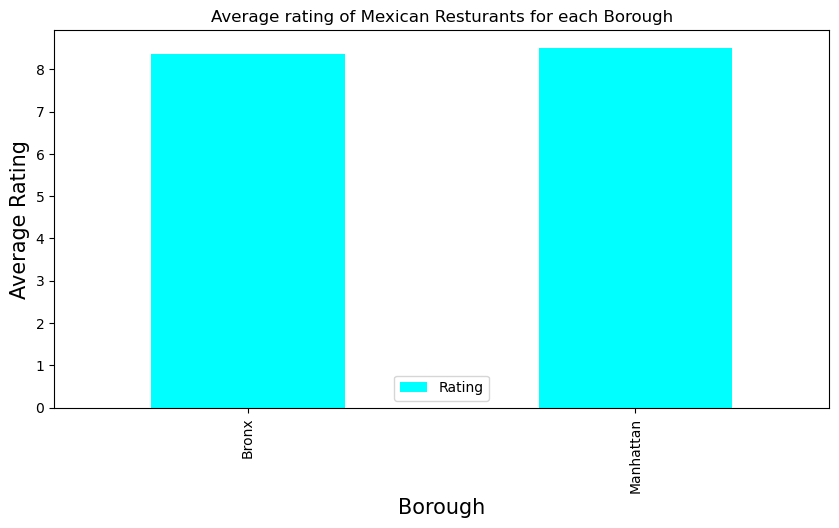

In [95]:
plt.figure(figsize=(10,5), dpi=100)
# title
plt.title('Average rating of Mexican Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize=15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
mexican_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color='aqua')
#legend
plt.legend()
#displays the plot
plt.show()

Lets find neighborhoods with average rating greater or equal to 7.0 to visualize on a map:

In [97]:
ny_neighborhood_stats = ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Baychester,8.400000
1,Bedford Park,8.500000
2,City Island,8.266667
3,Co-op City,8.075000
4,Eastchester,8.300000
5,Fieldston,8.225000
6,Kingsbridge,8.225000
7,Marble Hill,8.500000
8,Morris Heights,8.533333
9,Norwood,8.566667


Now lets join this dataset to new york data to get lonitude and latitude:

In [98]:
ny_neighborhood_stats = pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats = ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Baychester,40.866858,-73.835798,8.400000
1,Bronx,Bedford Park,40.870185,-73.885512,8.500000
2,Bronx,City Island,40.847247,-73.786488,8.266667
3,Bronx,Co-op City,40.874294,-73.829939,8.075000
4,Bronx,Eastchester,40.887556,-73.827806,8.300000
5,Bronx,Fieldston,40.895437,-73.905643,8.225000
6,Bronx,Kingsbridge,40.881687,-73.902818,8.225000
7,Manhattan,Marble Hill,40.876551,-73.910660,8.500000
8,Bronx,Morris Heights,40.847898,-73.919672,8.533333
9,Bronx,Norwood,40.877224,-73.879391,8.566667


Lets map the data:

In [116]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10)

In [117]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big the circle markers will be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Add a new field to dataframe for labeling purpose:

In [118]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

Add pop-up text to each marker on the map:

In [119]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Make this Notebook Trusted to load map: File -> Trust Notebook

Now lets visualize boroughs based on average rating:

In [124]:
ny_map2 = folium.Map(location=geo_location('New York'), zoom_start=10)

In [127]:
# instantiate a feature group for the incidents in the dataframe
incidents2 = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big the circle markers will be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [131]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [132]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## 4. Evaluation

After all the analysis that was perform we have found the needed information to decide where would be the ideal place to open the new restaurant.

## 5. Deployment

This project could be implemented into a regression algorithm for further development.

## 6. Conclusions

This project has led us to conclude that:

- Manhattan is the best place to open the restaurant since there is little competition
- Along with Manhattan, Queens and Brooklyn have good market potential for a new restaurant
- There aren't areas lacking Mexican Restaurants but there are areas with low number of them